# Lesson 24 Attention & transformers

## Diffusion Unet  

* Notebook: [26_Diffusion_Unet](https://github.com/fastai/course22p2/blob/master/nbs/26_diffusion_unet.ipynb). 
* Puts together stuff that we have already seen, to create a stable diffusion model using Unet.  (Except for attention, which will be added later).
* Not going to go through it in detail, but here are some interesting highlights I noted:


### Up and down sampling

* Downsampling not done in the resblock, but rather as an added conv layer with stride 2. 
* Upsamping is done by follwoing a resblock using `nn.Upsample` (basically copies each pixel into a 2x2 grid) followed by a conv layer (stride 1).

### Saved Mixin
Uses a `Saved` mixin to save activations for the cross connections in the Unet model.

* Mixins rely on python's `mro` (method resolution order) to determine the order in which methods are called (i.e. the order of inheritance).
* I prefer to avoid implementation inheritance, but mixins are a common technique. 
 * Jeremy also presents (later) an alternative using a wrapper on the module (similar to a decorator).

In [2]:
class A:
    def __call__(self):
        super().__call__()
        print('a')

class B:
    def __call__(self): print('b')

class C(A,B): pass

C()() # create an instance of C, then call it

b
a


### Time Embedding (20:45)

* We would like an embedding where:
  * Any time step (in range) is represented with a unique embedding.
  * Deterministic 
  * Time steps that are close together should have embeddings that are close together (similar)
  * Embeddings are restricted to a fixed range (e.g. -1 to 1).

* Sinusoidal embedding is a common technique for this.

$$
\text{PE}_{(\text{pos}, 2i)} = \sin\left(\frac{\text{pos}}{10000^{\frac{2i}{d_{\text{model}}}}}\right)
$$
$$
\text{PE}_{(\text{pos}, 2i+1)} = \cos\left(\frac{\text{pos}}{10000^{\frac{2i}{d_{\text{model}}}}}\right)
$$

* Basically a sin and cos wave with different frequencies, sin waves for even indices and cos waves for odd indices in the embedding.
* 'i' here goes from 0 to d_model//2 and for each there are two waves at each corresponding frequency. 

* The period starts at $2 \pi$ and with increasing $i$ exponentially increases toward the max period of $2 \pi \times 10000$.  (Log period increases linearly)  


* Same idea is used for Transformer models to encode token position. There the embedding is added to the input embeddings.


From [Attention is All You Need](https://arxiv.org/abs/1706.03762):
>We chose this function because we hypothesized it would allow the model to easily learn to attend by
relative positions, since for any fixed offset $k$, $PE_{\text{pos}+k}$ can be represented as a linear function of
$PE_{\text{pos}}$."

It can be shown that the linear relationship between to positional embeddings is a rotation in the space of the pairs of embeddings.  (See https://huggingface.co/blog/designing-positional-encoding  )

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import math

tsteps = torch.linspace(-10,10,100) # jeremy: this doesn't make sense but it's just for illustration ?

# really this is max_period/ (2*pi)  but lets not quibble
max_period = 10000  # Magic number From transformer paper, for 10k tokens, so why are we using it? 

emb_dim = d_model = 16 # embedding size

exponent = -math.log(max_period) * torch.linspace(0, 1, emb_dim//2)     # log of the denominator 
emb = tsteps[:, None].float() * exponent.exp()[None, :]  # scaled positions
emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)  # sin/cos embedding

In [4]:
emb.shape

torch.Size([100, 16])

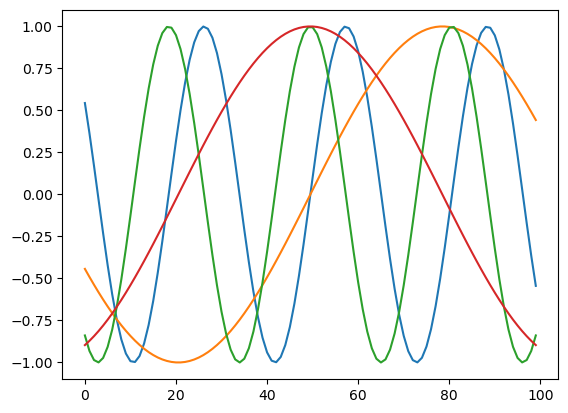

In [5]:

plt.plot(emb[:,0])
plt.plot(emb[:,1])
#plt.plot(emb[:,5])

plt.plot(emb[:,8])
plt.plot(emb[:,9])


<Axes: >

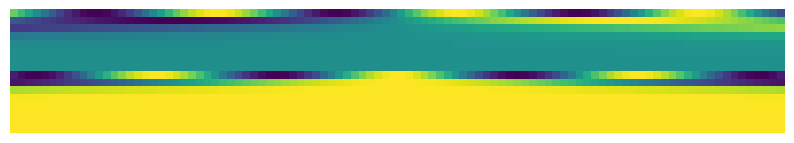

In [6]:
from minai.datasets import show_image
show_image(emb.T, figsize=(10,10))

Each column is a different embedding for each time step. (we can embed much more, up to 10000!)

### An Amusing Analogy for Positional Encoding

- Imagine each **sine-cosine pair** as controlling the **rotation of a knob**. The position of a token determines the angle of rotation for each knob.  

- **Knobs rotate at different speeds**:
  - **Low-frequency knobs** (longer wavelengths) act as **coarse controls**, capturing large-scale positional changes.  
  - **High-frequency knobs** (shorter wavelengths) act as **fine controls**, detecting subtle, small-scale positional variations.  

- Together, these knobs create a **rich, multi-scale encoding of position**, enabling the model to:  
  - Attend to **global positional relationships** through coarse knobs.  
  - Attend to **local positional relationships** through fine knobs.  

- **Why sine and cosine?**  
  Sine and cosine can be thought of as the **x and y coordinates** of a point on a unit circle. As the angle changes (i.e., as you "rotate the knob"), the sine and cosine values trace out the circular motion. This makes them perfect for encoding positions as they are **continuous, periodic**, and naturally represent rotational motion.

- **Linear relationships in encoding**:
  - The positional encoding of one position is **linearly related** to another. This is because moving between positions corresponds to **rotating the knobs**, which can be mathematically represented by a **rotation matrix** for each sine-cosine pair.


In [7]:
def timestep_embedding(tsteps, emb_dim, max_period= 10000):
    exponent = -math.log(max_period) * torch.linspace(0, 1, emb_dim//2, device=tsteps.device)
    emb = tsteps[:,None].float() * exponent.exp()[None,:]
    emb = torch.cat([emb.sin(), emb.cos()], dim=-1)
    return F.pad(emb, (0,1,0,0)) if emb_dim%2==1 else emb

<Axes: >

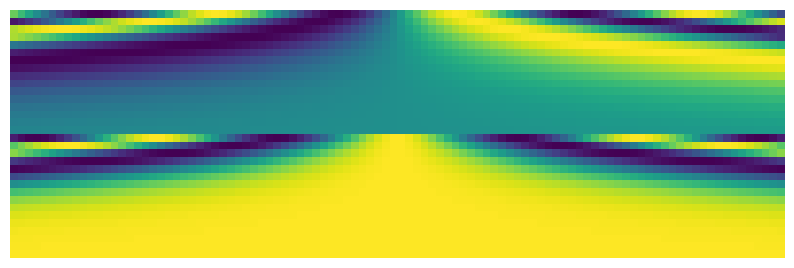

In [8]:
show_image(timestep_embedding(tsteps, 32, max_period=100).T, figsize=(10,10))    # show with smaller max period and more dimensions.

Jeremy comments that if you are wasteful with max_timesteps, you probably need much higher embedding dimension. 

<Axes: >

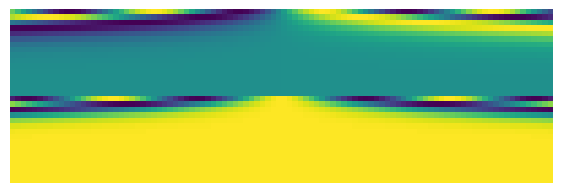

In [9]:
show_image(timestep_embedding(tsteps,32 , max_period=10000).T, figsize=(7,7)) 

<Axes: >

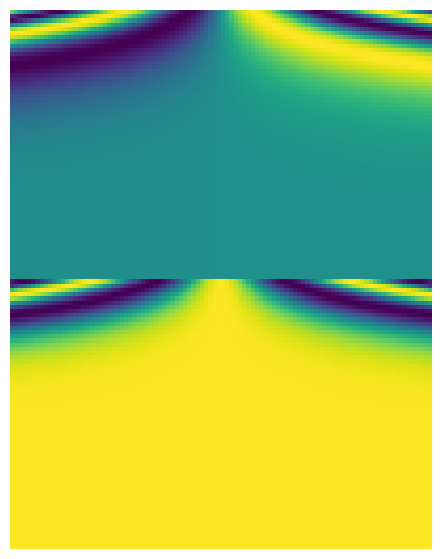

In [10]:
show_image(timestep_embedding(tsteps,128 , max_period=10000).T, figsize=(7,7)) 

Here is a case where the max period matches the max timestep.

<Axes: >

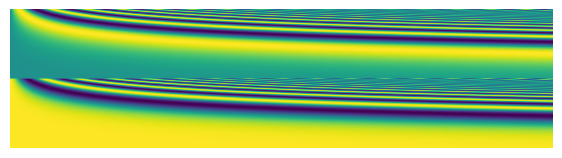

In [11]:
tsteps = torch.linspace(0, 100,1000)
show_image(timestep_embedding(tsteps, 256 , max_period=100*2*math.pi).T, figsize=(7,7)) 

For more on positinal encoding see : https://huggingface.co/blog/designing-positional-encoding 

### What do we do with the time embedding?

- We could concatenate or add it to the input (like in transformers).  
- In stable diffusion, the embedding is used to scale and shift the activations in a learned way:
  - The embedding is passed trhough a projection layger (n_emb inputs -> 2*activations output)
  - This is then and `chunked` into two parts.
  - The first part is used to scale the activations, the second to shift the activations.
  - See EmbResBlock in the notebook.

- Other than that, it is otherwise just a normal resblock in our unet model. 
- Note that the timestep embedding is passed into each resnet to do the scaling and shifting.
- The time embedding at the model level also gets a MLP to allow the model some flexiblity  (See EmbENetModel in the notebook).


### Train and sample

- Jeremy trains the model (on FashionMNIST) (noise prediction)
- Sampling from teh model gives similar FID scores to the stable diffusion model (from Diffusers librar) from previous weeks.
- Still missing one component - attention.

## Attention 

Starts at 48:00

Notebook: 27_attention.ipynb

- Two reasons for introducing attention here:
    - Attention is used in the stable diffusion model, which we are building here. We wont see significant improvement here with it though.
    - Attention is a key component of transformers like GPT, which he says we will see later (Part 3). I don't believe Part 3 ever materialized.


- Basic idea of attention (in image context) is to allow features at one location to attend to features at other locations, since what is important in one location may depend on what is happening elsewhere in the image.

- Attention is a weighted average of the features at all locations in the image. The weights are determined by the similarity of the features at the different locations.
- We will use 1D attention, which was designed for lines of text, but can be used for images as well if we flatten them out.

- If $x_i$ is the vector of features at location $i$ then a waited average looks like: 


  $$
  x_i -> x_i + \sum_j w_j  x_j
  $$

  where $x_i$ is the vector of features at location $i$ and $w$ is the weight. If we define $\mathbf{X}$ as the matrix of features at all locations (dimensions features x location), then the above can be written as:

  $$
  \mathbf{X} + \mathbf{W} \mathbf{X}  
  $$

  where $\mathbf{W}$ is a weight matrix.

- The weights are determined by the similarity of the features at the different locations, using the dot product of the features at the different locations.

  $$
  \mathbf{X} \mathbf{X}^T
  $$

  this will have dimension location x location and if normalized could be our weight matrix. We use the softmax to accomplish this.

 

- To make the attention more flexible, we multiply each $\mathbf{X}$ by three learnable matrices, $W_q$, $W_k$, and $W_n$ (query, key, and value), resulting in the final result: 


  $$
  \text{attention} =  \text{softmax}\left(\frac{\mathbf{W_q X} (\mathbf{W_k X})^T}{\sqrt{d_k}}\right)  \mathbf{W_v X} =\text{softmax}\left(\frac{\mathbf{Q} \mathbf{K}^T}{\sqrt{d_k}}\right)  \mathbf{V}
  $$

- See the notebook 27 for the implementation of this in pytorch.



- Multiheaded attention overcoems the limitation of a single head to attend to multiple things at once. (See notebook for details)

### Using the attention in the diffusion model

Notebook 28_diffusion-attn-cond.ipynb 

- He add attention to the diffusion model at the resblock level
- The attention output is simply added to the output at the end of the resblock.
- See EmbResBlock in the notebook.
- At higher levels we pass in the attn_channels to flow down to the Res block.
- At the top level , you also have to say at what block to start using attention. This is to avoid having too big a model with attention at the first block.
- Results form training are not significantly better than without (as mentioned before)

### Note on Transformer

- We really have everything we need to understand transformers now.
- Transformer alternates between self attention (mostly mixing different positions) and feed forward MLP (mixing different channels on each pixel on its own).
- They generally use sinusoidal positional encoding (added to the input instead of the scaling and shifting we did in the diffusion model).
- Very flexible and has been shown to be able to approximate any convolution. The problem is it requires a lot of data and compute to train. BUt pre-trained models are very successful (pretrained on large dataset, and then trained on smaller dataset, like imageNet). 
- The Vision Transformer is a good example and works better then resnet. Finds something better then convolution !
- NB GPT stands for Generative *Pretrained* Transformer. For a pedagocial introduction to transformers, see [The Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/).  Also see a full (pedagogical) implementation of GPT-2 at [GPT-2](https://github.com/karpathy/nanoGPT)

In [ ]:
def _mlp(ni, nh):
    return nn.Sequential(nn.Linear(ni,nh), nn.GELU(), nn.LayerNorm(nh), nn.Linear(nh,ni))

class TransformerBlk(nn.Module):
    def __init__(self, n_emb, ni, attn_chans=8):
        super().__init__()
        self.attn = SelfAttention(ni, attn_chans=attn_chans, transpose=False)
        self.mlp = _mlp(ni, ni*4)
        self.nrm1 = nn.LayerNorm(ni)
        self.nrm2 = nn.LayerNorm(ni)

    def forward(self, x, t):
        x = x + self.attn(self.nrm1(x))
        x = x*(1+scale) + shift
        return x + self.mlp(self.nrm2(x))

## Conditional model

starts at 1:49 in the video

- Use a normal learned embedding for each class in FashionMNIST. 
- The embedding is simply added to the time embedding and used as before  
- Trains well.
- To sample we have to also  pass in also the class . 
- Most everything else is the same.

See 28_diffusion-attn-cond.ipynb (local copy)

- Note that the training uses all of my 8GB of GPU, so moved it to paperspace.
- Paperspace is a pain to set up the dependencies (conda was not there), but got it working trained 10 epochs quickly.
- Even so had to be careful when sampling to clear the memory. 

## Summary

We have implemented everything in stable diffusion except:
- Latent diffusion 
- Passing in full sentances. (I dont think we will do this)